<a href="https://colab.research.google.com/github/priscillalea/f1-winner-predictor/blob/main/f1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saved: pitstop_performance_official_colors.png, pitstop_performance_official_colors.svg
Saved: qualifying_performance_official_colors.png, qualifying_performance_official_colors.svg
Saved: raceday_performance_official_colors.png, raceday_performance_official_colors.svg
           🏁F1 2025 PERFORMANCE REPORT🏁           

--- Season Analysis ---
Best team in pit stops: **Haas** with an average time of **2.411** seconds.
Driver with best qualifying performance: **Lando Norris** with **4** pole positions.
Driver with best race day performance: **Oscar Piastri** with **6** wins.

--- Data Visualization ---
Performance charts generated successfully:


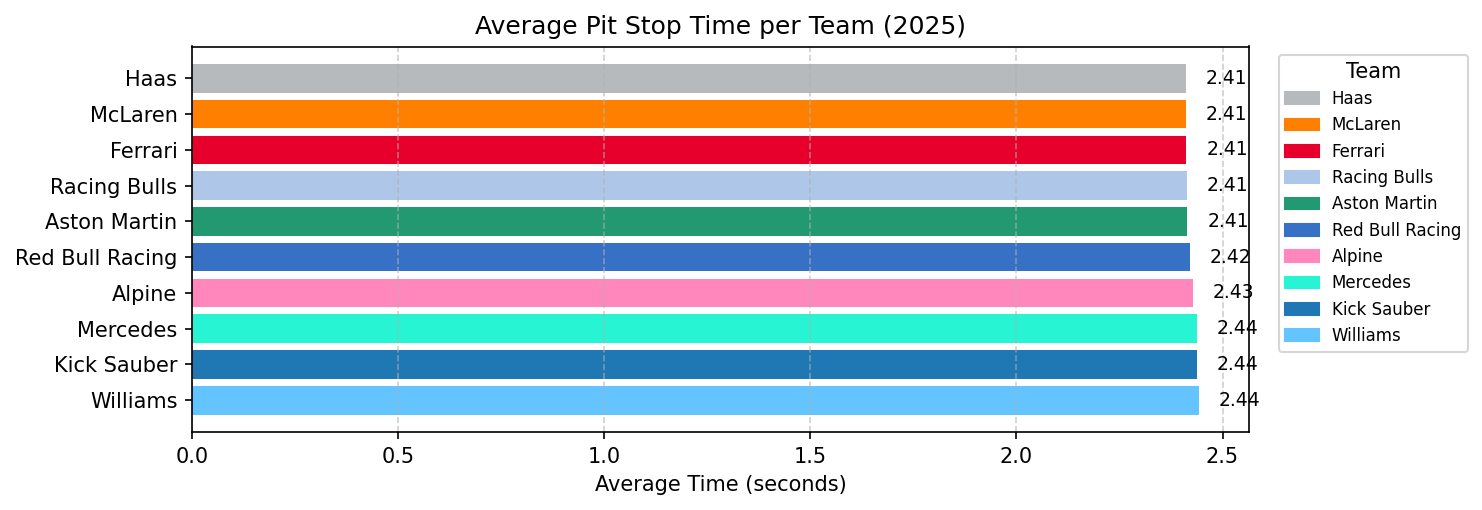

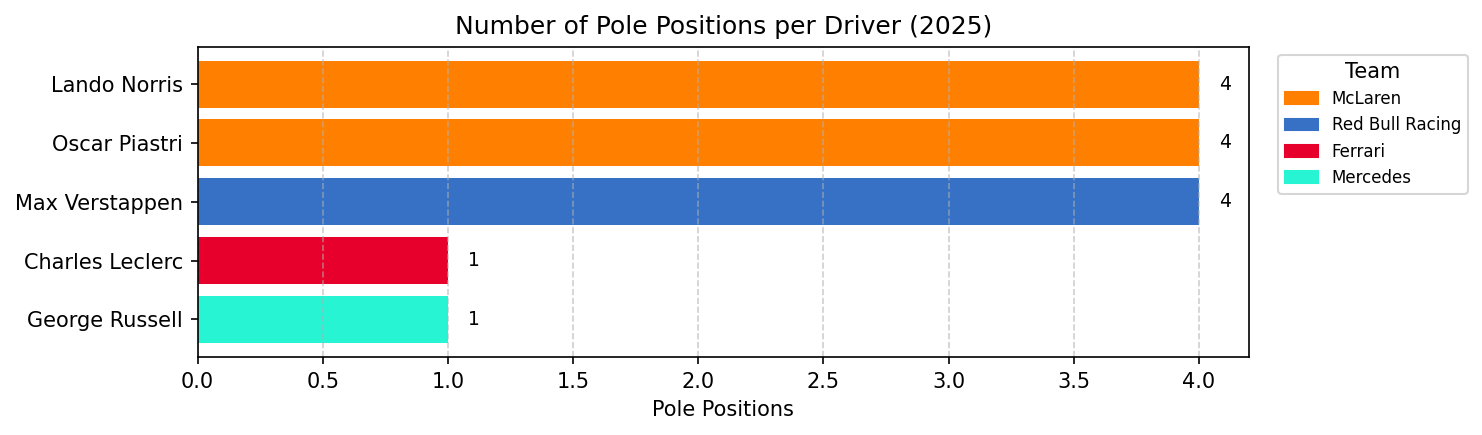

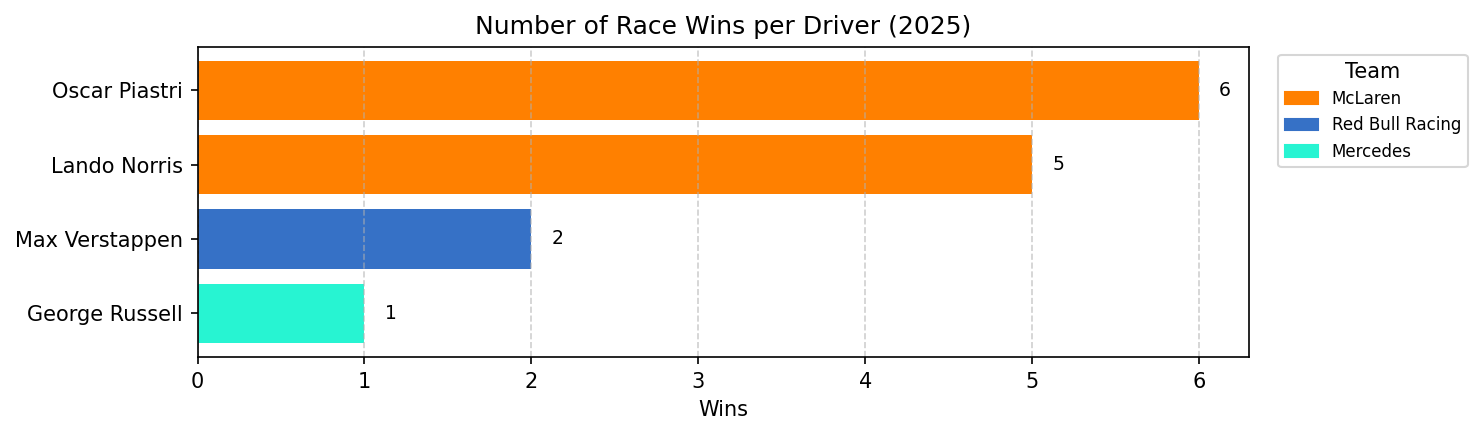

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from IPython.display import Image, display
import os

plt.rcParams.update({'font.size': 10})

# Load data
paths = {
    'pitstop': '/content/content/csv/pitstop.csv',
    'qualifying': '/content/content/csv/qualifying.csv',
    'race': '/content/content/csv/raceresult.csv'
}
for k, p in paths.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"File not found: {p}")

pitstop_df = pd.read_csv(paths['pitstop'])
qualifying_df = pd.read_csv(paths['qualifying'])
race_result_df = pd.read_csv(paths['race'])

team_colors_official = {
    "Red Bull Racing": "#3671C6",
    "Ferrari": "#E8002D",
    "Mercedes": "#27F4D2",
    "McLaren": "#FF8000",
    "Alpine": "#FF87BC",
    "Aston Martin": "#229971",
    "Williams": "#64C4FF",
    "Haas": "#B6BABD",
    "AlphaTauri": "#6692FF"
}
#Standardise the names
team_aliases = {
    'Scuderia Ferrari': 'Ferrari',
    'Mercedes-AMG Petronas': 'Mercedes',
    'BWT Alpine': 'Alpine',
    'Williams Racing': 'Williams',
    'RB Formula One Team': 'AlphaTauri',
}
def normalize_team_name(name):
    if pd.isna(name):
        return name
    return team_aliases.get(name, name)

for df in (pitstop_df, qualifying_df, race_result_df):
    if 'team' in df.columns:
        df['team'] = df['team'].map(normalize_team_name)

# Consolidate all teams, create fallback colors
all_teams = set()
for df in (pitstop_df, qualifying_df, race_result_df):
    if 'team' in df.columns:
        all_teams.update(df['team'].dropna().unique())

cmap = plt.get_cmap('tab20')
fallback_teams = [t for t in sorted(all_teams) if t not in team_colors_official]
fallback_colors = {t: mcolors.to_hex(cmap(i % cmap.N)) for i, t in enumerate(fallback_teams)}
team_colors_global = {**{k: v for k, v in team_colors_official.items() if k in all_teams}, **fallback_colors}
default_color = (0.6, 0.6, 0.6)

# Helper function to determine if a color is "white-like"
def is_color_white(color_hex):
    """Checks if a hex color is close to white based on its luminance."""
    try:
        rgb = mcolors.hex2color(color_hex)
        # Calculate luminance (a common way to perceive brightness)
        luminance = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
        return luminance > 0.9  # Threshold for considering a color "white-like"
    except ValueError:
        return False # Not a valid hex color


#Create horizontal bars instead of vertical ones. Easier to visualize the data
def plot_horizontal_bars(series, item_to_team=None, title='', xlabel='', fname='plot', top_n=None, save_svg=True):
    """
    series: pd.Series indexed by label (driver or team) with numeric values
    item_to_team: mapping from label -> team (optional). If None, labels are teams.
    fname: base filename without extension (will save .png and optional .svg)
    """
    if series.empty:
        print(f"Warning: Empty series for '{title}'")
        return

    # Sort series (ascending for smaller values, descending for larger)
    ascending = series.index.size > 0 and series.iloc[0] > series.iloc[-1]
    s = series.sort_values(ascending=not ascending)
    # Maping item to team
    labels = list(s.index)
    teams = []
    for lab in labels:
        if item_to_team is not None:
            teams.append(item_to_team.get(lab, None))
        else:
            teams.append(lab)

    # Determine colors and edgecolors
    colors = []
    edgecolors = []
    linewidths = []
    for t in teams:
        col = team_colors_global.get(t, default_color)
        colors.append(col)
        if is_color_white(col):
            edgecolors.append('black')
            linewidths.append(0.8)
        else:
            edgecolors.append(None)
            linewidths.append(0.0)

    height = max(3, 0.35 * len(s))
    plt.figure(figsize=(10, height), dpi=150)
    ax = plt.gca()
    # Filter out None from edgecolors and linewidths before passing to barh
    valid_edgecolors = [ec for ec in edgecolors if ec is not None]
    valid_linewidths = [lw for ec, lw in zip(edgecolors, linewidths) if ec is not None]

    # Visual core of the graphic
    bars = ax.barh(labels, s.values, color=colors, edgecolor=valid_edgecolors if valid_edgecolors else None, linewidth=valid_linewidths if valid_linewidths else 0)
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.grid(axis='x', linestyle='--', alpha=0.6)

    # values - graph
    for bar in bars:
        w = bar.get_width()
        xpos = w + 0.02 * (s.max() if s.max() != 0 else 1)
        text = f'{w:.2f}' if not float(w).is_integer() else f'{int(w)}'
        ax.text(xpos, bar.get_y() + bar.get_height()/2, text, va='center', fontsize=9)


    # legend - graph
    shown = []
    handles = []
    for t in teams:
        if t is not None and t not in shown:
            shown.append(t)
    for t in shown:
        if t in team_colors_global:
            handles.append(mpatches.Patch(color=team_colors_global[t], label=t))
    if handles:
        ax.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8, title='Team')

    # Finish and save the chart
    plt.tight_layout()
    png_file = f"{fname}.png"
    plt.savefig(png_file, bbox_inches='tight', dpi=150)
    if save_svg:
        svg_file = f"{fname}.svg"
        plt.savefig(svg_file, bbox_inches='tight')
    plt.close()
    print(f"Saved: {png_file}" + (f", {svg_file}" if save_svg else ""))



# PITSTOPS: Average time per team (the slower is the best)
pitstop_df['time'] = pd.to_numeric(pitstop_df['time'], errors='coerce')
avg_pitstop_time = pitstop_df.groupby('team')['time'].mean().dropna().sort_values()
# For pitstops, index are teams, so item_to_team is identity mapping
identity_team_map = {team: team for team in avg_pitstop_time.index}
plot_horizontal_bars(avg_pitstop_time, item_to_team=identity_team_map,
                     title='Average Pit Stop Time per Team (2025)',
                     xlabel='Average Time (seconds)',
                     fname='pitstop_performance_official_colors',
                     top_n=None, save_svg=True)


# QUALIFYING: Poles per driver
if 'pos' in qualifying_df.columns and 'driver' in qualifying_df.columns:
    # Convert 'pos' to numeric before filtering
    qualifying_df['pos'] = pd.to_numeric(qualifying_df['pos'], errors='coerce')
    poles = qualifying_df[qualifying_df['pos'] == 1].groupby('driver').size().sort_values(ascending=False)
    if 'team' in qualifying_df.columns:
        driver_team = qualifying_df.groupby('driver')['team'].agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0]).to_dict()
    else:
        driver_team = {}
    plot_horizontal_bars(poles, item_to_team=driver_team,
                         title='Number of Pole Positions per Driver (2025)',
                         xlabel='Pole Positions',
                         fname='qualifying_performance_official_colors',
                         top_n=None, save_svg=True)
else:
    print("Qualifying CSV does not have expected columns ('pos' and 'driver').")



# RACE: Wins per driver
race_result_df = race_result_df.rename(columns={'race_id': 'event_id'})
if 'pos' in race_result_df.columns and 'driver' in race_result_df.columns:
    # Convert 'pos' to numeric before filtering
    race_result_df['pos'] = pd.to_numeric(race_result_df['pos'], errors='coerce')
    wins = race_result_df[race_result_df['pos'] == 1].groupby('driver').size().sort_values(ascending=False)
    if 'team' in race_result_df.columns:
        driver_team_r = race_result_df.groupby('driver')['team'].agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0]).to_dict()
    else:
        driver_team_r = {}
    plot_horizontal_bars(wins, item_to_team=driver_team_r,
                         title='Number of Race Wins per Driver (2025)',
                         xlabel='Wins',
                         fname='raceday_performance_official_colors',
                         top_n=None, save_svg=True)
else:
    print("Race results CSV does not have expected columns ('pos' and 'driver').")


# RESULT
print("=====================================================")
print("           🏁F1 2025 PERFORMANCE REPORT🏁           ")
print("=====================================================")
print("\n--- Season Analysis ---")
if not avg_pitstop_time.empty:
    best_pitstop_team = avg_pitstop_time.index[0]
    best_pitstop_time = avg_pitstop_time.iloc[0]
    print(f"Best team in pit stops: **{best_pitstop_team}** with an average time of **{best_pitstop_time:.3f}** seconds.")
else:
    print("No pit stop data.")

if 'poles' in locals() and not poles.empty:
    best_qualifying_driver = poles.index[0]
    best_qualifying_poles = int(poles.iloc[0])
    print(f"Driver with best qualifying performance: **{best_qualifying_driver}** with **{best_qualifying_poles}** pole positions.")
else:
    print("No qualifying data (poles).")

if 'wins' in locals() and not wins.empty:
    best_race_driver = wins.index[0]
    best_race_wins = int(wins.iloc[0])
    print(f"Driver with best race day performance: **{best_race_driver}** with **{best_race_wins}** wins.")
else:
    print("No race wins data (race results).")

print("\n--- Data Visualization ---")
print("Performance charts generated successfully:")
try:
    display(Image('pitstop_performance_official_colors.png'))
    display(Image('qualifying_performance_official_colors.png'))
    display(Image('raceday_performance_official_colors.png'))
except Exception:
    print("Could not display images. Ensure they were saved correctly.")

print("\n=====================================================")